In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import string
from numpy.random import normal,random,seed
from scipy.stats import norm
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV,cross_val_score,train_test_split
from sklearn.metrics import log_loss
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('V5.csv')

In [4]:
df.head()

,Unnamed: 0,Unnamed: 0.1,DATE_ID,CAMPAIGN,KEYWORD,_POSITION,CLICKS,CPC,IMPRESSIONS,MEDIA_COST,CTR,Flag,CAMP_ID,week,KW_ID,Q,NETWORK_Bing,NETWORK_Google,NETWORK_Yahoo,CAMPAIGN_TYPE_Branded,CAMPAIGN_TYPE_Unbranded,cluster_assignment,cluster_name,RF_classsifier_prediction,XG_classsifier_prediction
0,0,0,20170521,Non Brand | Condition | Geo,symptoms of asthma,2.08,3,1.8,51,5.4,0.058824,1,1,7,1,2,0,1,0,0,1,13,asthma symptoms and causes,1,1
1,1,1,20170521,Brand,product1 spacer,1.00,0,0.0,2,0.0,0.000000,0,2,7,2,2,0,1,0,1,0,1,"product1 inhaler/spacer uses, coupons & instru...",0,0
2,2,2,20170521,Non Brand | Treatment | National,how to prevent asthma,1.48,0,0.0,4,0.0,0.000000,0,3,7,3,2,0,1,0,0,1,2,"asthma facts, causes, prevention & relief/control",0,0
3,3,3,20170521,Non Brand | Info | Geo,facts about asthma,0.00,0,0.0,0,0.0,0.000000,0,4,7,4,2,1,0,0,0,1,2,"asthma facts, causes, prevention & relief/control",0,0
4,4,4,20170521,Non Brand | Condition | Geo,asthma symptoms in children,0.00,0,0.0,0,0.0,0.000000,0,1,7,5,2,1,0,0,0,1,19,asthma symptoms & causes in children,0,0


In [5]:
#Perfrom log transformation because the CTR and Clicks are clustered to floor and ceiling

df['logCTR'] = np.log(df['CTR']+1)
df['logClicks'] = np.log(df['CLICKS']+1)
df['logImpression'] = np.log(df['IMPRESSIONS']+1)
df.head(5)

,Unnamed: 0,Unnamed: 0.1,DATE_ID,CAMPAIGN,KEYWORD,_POSITION,CLICKS,CPC,IMPRESSIONS,MEDIA_COST,CTR,Flag,CAMP_ID,week,KW_ID,Q,NETWORK_Bing,NETWORK_Google,NETWORK_Yahoo,CAMPAIGN_TYPE_Branded,CAMPAIGN_TYPE_Unbranded,cluster_assignment,cluster_name,RF_classsifier_prediction,XG_classsifier_prediction,logCTR,logClicks,logImpression
0,0,0,20170521,Non Brand | Condition | Geo,symptoms of asthma,2.08,3,1.8,51,5.4,0.058824,1,1,7,1,2,0,1,0,0,1,13,asthma symptoms and causes,1,1,0.057158,1.386294,3.951244
1,1,1,20170521,Brand,product1 spacer,1.00,0,0.0,2,0.0,0.000000,0,2,7,2,2,0,1,0,1,0,1,"product1 inhaler/spacer uses, coupons & instru...",0,0,0.000000,0.000000,1.098612
2,2,2,20170521,Non Brand | Treatment | National,how to prevent asthma,1.48,0,0.0,4,0.0,0.000000,0,3,7,3,2,0,1,0,0,1,2,"asthma facts, causes, prevention & relief/control",0,0,0.000000,0.000000,1.609438
3,3,3,20170521,Non Brand | Info | Geo,facts about asthma,0.00,0,0.0,0,0.0,0.000000,0,4,7,4,2,1,0,0,0,1,2,"asthma facts, causes, prevention & relief/control",0,0,0.000000,0.000000,0.000000
4,4,4,20170521,Non Brand | Condition | Geo,asthma symptoms in children,0.00,0,0.0,0,0.0,0.000000,0,1,7,5,2,1,0,0,0,1,19,asthma symptoms & causes in children,0,0,0.000000,0.000000,0.000000


In [6]:
np.isfinite(df.logCTR).all()

False

In [7]:
np.where(df.logCTR >= np.finfo(np.float64).max)

(array([ 81826, 245823], dtype=int64),)

In [8]:
df["logCTR"].iloc[81826] = 0
df["logCTR"].iloc[245823] = 0

C:\Users\zjx04\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [9]:
np.isfinite(df.logClicks).all()

True

In [10]:
np.isfinite(df.logImpression).all()

True

In [9]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'DATE_ID', 'CAMPAIGN', 'KEYWORD',
       '_POSITION', 'CLICKS', 'CPC', 'IMPRESSIONS', 'MEDIA_COST', 'CTR',
       'Flag', 'CAMP_ID', 'week', 'KW_ID', 'Q', 'NETWORK_Bing',
       'NETWORK_Google', 'NETWORK_Yahoo', 'CAMPAIGN_TYPE_Branded',
       'CAMPAIGN_TYPE_Unbranded', 'cluster_assignment', 'cluster_name',
       'RF_classsifier_prediction', 'XG_classsifier_prediction', 'logCTR',
       'logClicks', 'logImpression'],
      dtype='object')

### Regression on log CTR

In [13]:
#remove CPC and keep media_cost
X = df.drop(['DATE_ID','CAMPAIGN','KEYWORD','IMPRESSIONS','CTR','Flag','CLICKS','logCTR','logClicks','CPC',
             'logImpression','Unnamed: 0','cluster_name','KW_ID','Unnamed: 0.1','RF_classsifier_prediction',
            'XG_classsifier_prediction'], axis=1)
Y = df['logCTR'].values

In [13]:
X['CAMP_ID'].isnull().sum()

0

In [14]:
np.isfinite(Y).all(), np.isfinite(X).all()

(True,
 _POSITION                    True
 MEDIA_COST                   True
 CAMP_ID                      True
 week                         True
 Q                            True
 NETWORK_Bing                 True
 NETWORK_Google               True
 NETWORK_Yahoo                True
 CAMPAIGN_TYPE_Branded        True
 CAMPAIGN_TYPE_Unbranded      True
 cluster_assignment           True
 RF_classsifier_prediction    True
 XG_classsifier_prediction    True
 dtype: bool)

In [15]:
np.any(np.isnan(X)), np.any(np.isnan(Y))

(False, False)

In [14]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state=121)

In [15]:
x_train.head()

,_POSITION,MEDIA_COST,CAMP_ID,week,Q,NETWORK_Bing,NETWORK_Google,NETWORK_Yahoo,CAMPAIGN_TYPE_Branded,CAMPAIGN_TYPE_Unbranded,cluster_assignment
121695,8.00,0.00,9,7,1,1,0,0,0,1,9
377647,1.89,21.78,9,4,2,0,1,0,0,1,16
280973,4.72,0.00,6,5,3,1,0,0,0,1,7
64168,4.00,0.00,5,4,1,1,0,0,0,1,2
45024,4.67,0.00,1,5,2,0,1,0,0,1,2


#### Base RF model

In [16]:
rf = RandomForestRegressor(n_estimators=400, min_samples_leaf=0.12, random_state=121)
rf.fit(x_train, y_train)

# Predict the test set labels 'y_pred'
y_pred = rf.predict(x_test)
y_pred_train = rf.predict(x_train)

In [17]:
def RMSE(x,y): 
    return np.mean((x - y)**2)**0.5

In [18]:
# Evaluate the test set RMSE
rmse_test = RMSE(y_test, y_pred)
rmse_train = RMSE(y_train, y_pred_train)

# Print the test set RMSE
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))
print('Train set RMSE of rf: {:.2f}'.format(rmse_train))

Test set RMSE of rf: 0.10
Train set RMSE of rf: 0.10


In [19]:
r2_train = np.corrcoef(y_train, y_pred_train)**2
r2_test = np.corrcoef(y_test, y_pred)**2

In [20]:
r2_train, r2_test

(array([[1.       , 0.4560609],
        [0.4560609, 1.       ]]),
 array([[1.        , 0.45646849],
        [0.45646849, 1.        ]]))

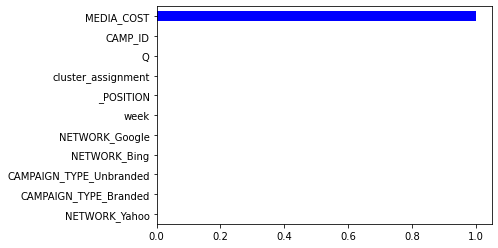

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
# Create a pd.Series of features importances
importances_rf = pd.Series(rf.feature_importances_, index = X.columns)
# Sort importances_rf
sorted_importances_rf = importances_rf.sort_values()
# Make a horizontal bar plot
sorted_importances_rf.plot(kind='barh', color='blue')
plt.show()

In [22]:
rf.get_params

<bound method BaseEstimator.get_params of RandomForestRegressor(min_samples_leaf=0.12, n_estimators=400, random_state=121)>

#### Randomize Search RF

In [65]:
param_grid = {'max_features': [6, 8, 'auto', 'log2'],
              'min_samples_leaf': [0.08, 0.10, 0.12],
              'n_estimators': [300, 400, 500]}

In [66]:
rf0 = RandomForestRegressor(random_state=12, oob_score = True, bootstrap = True)

In [67]:
from sklearn.model_selection import RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator = rf0, param_distributions = param_grid, scoring = "r2",
                               n_iter = 10, cv = 3, verbose = 1, n_jobs = -1)

In [68]:
rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 13.0min finished


RandomizedSearchCV(cv=3,
                   estimator=RandomForestRegressor(oob_score=True,
                                                   random_state=12),
                   n_jobs=-1,
                   param_distributions={'max_features': [6, 8, 'auto', 'log2'],
                                        'min_samples_leaf': [0.08, 0.1, 0.12],
                                        'n_estimators': [300, 400, 500]},
                   scoring='r2', verbose=1)

In [71]:
rf_random.best_params_

{'n_estimators': 400, 'min_samples_leaf': 0.12, 'max_features': 'auto'}

In [72]:
print('train RMSE =', RMSE(y_test, rf_random.best_estimator_.predict(x_test)))

train RMSE = 0.09768743094671042


In [73]:
print("r2_train", np.corrcoef(y_train, rf_random.best_estimator_.predict(x_train))**2)
print("r2_test", np.corrcoef(y_test, rf_random.best_estimator_.predict(x_test))**2)

r2_train [[1.        0.4560609]
 [0.4560609 1.       ]]
r2_test [[1.         0.45646849]
 [0.45646849 1.        ]]


#### Base XGboost model

In [90]:
param = {'objective': 'reg:squarederror'}

In [76]:
dtrain = xgb.DMatrix(x_train, label=y_train)

In [91]:
cvSearch = xgb.cv(param, dtrain, nfold = 3, num_boost_round = 100, verbose_eval = 10)
cvSearch.tail(10)

[0]	train-rmse:0.33670+0.00005	test-rmse:0.33671+0.00014
[10]	train-rmse:0.07059+0.00034	test-rmse:0.07139+0.00039
[20]	train-rmse:0.06809+0.00029	test-rmse:0.06967+0.00056
[30]	train-rmse:0.06707+0.00031	test-rmse:0.06936+0.00057
[40]	train-rmse:0.06636+0.00029	test-rmse:0.06919+0.00052
[50]	train-rmse:0.06566+0.00020	test-rmse:0.06908+0.00053
[60]	train-rmse:0.06511+0.00019	test-rmse:0.06905+0.00051
[70]	train-rmse:0.06458+0.00018	test-rmse:0.06902+0.00053
[80]	train-rmse:0.06407+0.00015	test-rmse:0.06902+0.00048
[90]	train-rmse:0.06359+0.00018	test-rmse:0.06901+0.00045
[99]	train-rmse:0.06315+0.00017	test-rmse:0.06904+0.00048


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
90,0.063588,0.000180,0.069008,0.000449
91,0.063555,0.000171,0.069003,0.000462
92,0.063522,0.000149,0.069004,0.000459
93,0.063467,0.000169,0.068996,0.000469
94,0.063406,0.000173,0.068994,0.000485
95,0.063349,0.000189,0.069004,0.000480
96,0.063301,0.000196,0.069028,0.000480
97,0.063251,0.000204,0.069025,0.000488
98,0.063205,0.000181,0.069032,0.000490
99,0.063151,0.000171,0.069039,0.000484


best number of rounds = 94
rmse = 0.06899433333333334


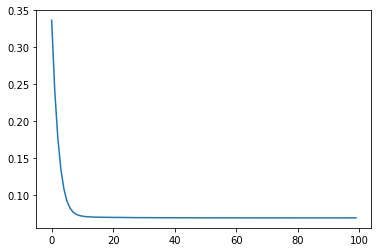

In [92]:
eps = 1e-6
bestNR = np.argmax(cvSearch['test-rmse-mean']<eps+min(cvSearch['test-rmse-mean']))
bestRMSE = cvSearch.loc[bestNR,'test-rmse-mean']
plt.plot(cvSearch['test-rmse-mean'])
print('best number of rounds =',bestNR)
print('rmse =',bestRMSE) 
#using bestNR

In [95]:
modelSearch = xgb.train(param, dtrain, num_boost_round = 95)
print(RMSE(y_test, modelSearch.predict(xgb.DMatrix(x_test))))

0.06788811506075422


In [96]:
print("r2_train", np.corrcoef(y_train, modelSearch.predict(xgb.DMatrix(x_train)))**2)
print("r2_test", np.corrcoef(y_test, modelSearch.predict(xgb.DMatrix(x_test)))**2)

r2_train [[1.         0.76402709]
 [0.76402709 1.        ]]
r2_test [[1.         0.73765336]
 [0.73765336 1.        ]]


In [81]:
regSearch = XGBRegressor(objective='reg:squarederror', random_state=42)
regSearch.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [84]:
regSearch.get_num_boosting_rounds()

100

In [85]:
regSearch.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'random_state': 42,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [86]:
print(RMSE(y_test, regSearch.predict(x_test)))

0.0678860107659058


In [87]:
print("r2_train", np.corrcoef(y_train, regSearch.predict(x_train))**2)
print("r2_test", np.corrcoef(y_test, regSearch.predict(x_test))**2)

r2_train [[1.         0.76466962]
 [0.76466962 1.        ]]
r2_test [[1.         0.73766503]
 [0.73766503 1.        ]]


In [97]:
regSearch1 = XGBRegressor(objective='reg:squarederror', learning_rate=0.35, n_estimators = 95, random_state=42)
regSearch1.fit(x_train, y_train)
print(RMSE(y_test, regSearch1.predict(x_test)))

0.06816535816763715


In [98]:
print("r2_train", np.corrcoef(y_train, regSearch1.predict(x_train))**2)
print("r2_test", np.corrcoef(y_test, regSearch1.predict(x_test))**2)

r2_train [[1.         0.76532865]
 [0.76532865 1.        ]]
r2_test [[1.         0.73545217]
 [0.73545217 1.        ]]


In [48]:
df0 = pd.read_csv('V5.csv')

#### Randomize Search XGboost

In [122]:
param_grid = {
    'learning_rate': [0.1, 0.15, 0.2, 0.25],
    'max_depth': [5,6],
    'n_estimators': [i*10 for i in range(9, 20)]
}

In [123]:
grid = RandomizedSearchCV(estimator = regSearch, scoring = 'r2',
                          param_distributions = param_grid, n_jobs=-1, cv=3)

grid.fit(x_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          gpu_id=-1, importance_type='gain',
                                          interaction_constraints='',
                                          learning_rate=0.300000012,
                                          max_delta_step=0, max_depth=6,
                                          min_child_weight=1, missing=nan,
                                          monotone_constraints='()',
                                          n_estimators=100, n_jobs=0,
                                          num_parallel_tree=1, random_state=42,
                                          reg_alpha=0, reg_lambda=1,
                                          scale_pos

In [124]:
grid.best_params_

{'n_estimators': 180, 'max_depth': 6, 'learning_rate': 0.15}

In [125]:
print(RMSE(y_test, grid.best_estimator_.predict(x_test)))

0.06788007871677024


In [126]:
print("r2_train", np.corrcoef(y_train, grid.best_estimator_.predict(x_train))**2)
print("r2_test", np.corrcoef(y_test, grid.best_estimator_.predict(x_test))**2)

r2_train [[1.         0.76069052]
 [0.76069052 1.        ]]
r2_test [[1.         0.73779665]
 [0.73779665 1.        ]]


#### k-fold cv search XGboost

In [104]:
# k-fold cross validation evaluation of xgboost model
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

model = XGBRegressor()
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
results = cross_val_score(model, X, Y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 73.59% (0.25%)


In [106]:
model = XGBRegressor(n_estimators = 130,
          learning_rate = 0.15,
          eval_metric = 'logloss',
          max_depth = 5,
          objective = 'reg:squarederror',
          subsample = 0.5, 
          random_sate=42)

In [107]:
model.fit(x_train, y_train)

[10:48:06] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { random_sate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.15, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=130, n_jobs=0,
             num_parallel_tree=1, random_sate=42, random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [108]:
print(RMSE(y_test, model.predict(x_test)))

0.06897266220073059


In [109]:
print("r2_train", np.corrcoef(y_train, model.predict(x_train))**2)
print("r2_test", np.corrcoef(y_test, model.predict(x_test))**2)

r2_train [[1.         0.74020682]
 [0.74020682 1.        ]]
r2_test [[1.        0.7295638]
 [0.7295638 1.       ]]


In [115]:
# best parameters dict
params = {
          'eta': 0.15,
          'eval_metric': 'rmse',
          'max_depth': 6,
          'objective': 'reg:squarederror',
          'subsample': 0.5
}

In [111]:
dtest = xgb.DMatrix(x_test, label=y_test)

In [116]:
model1 = xgb.train(
    params,
    dtrain,
    num_boost_round=200,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-rmse:0.40553
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.34690
[2]	Test-rmse:0.29733
[3]	Test-rmse:0.25583
[4]	Test-rmse:0.22087
[5]	Test-rmse:0.19170
[6]	Test-rmse:0.16758
[7]	Test-rmse:0.14760
[8]	Test-rmse:0.13131
[9]	Test-rmse:0.11793
[10]	Test-rmse:0.10724
[11]	Test-rmse:0.09869
[12]	Test-rmse:0.09201
[13]	Test-rmse:0.08689
[14]	Test-rmse:0.08277
[15]	Test-rmse:0.07974
[16]	Test-rmse:0.07745
[17]	Test-rmse:0.07577
[18]	Test-rmse:0.07431
[19]	Test-rmse:0.07320
[20]	Test-rmse:0.07252
[21]	Test-rmse:0.07197
[22]	Test-rmse:0.07145
[23]	Test-rmse:0.07109
[24]	Test-rmse:0.07079
[25]	Test-rmse:0.07043
[26]	Test-rmse:0.07018
[27]	Test-rmse:0.07000
[28]	Test-rmse:0.06987
[29]	Test-rmse:0.06975
[30]	Test-rmse:0.06969
[31]	Test-rmse:0.06966
[32]	Test-rmse:0.06961
[33]	Test-rmse:0.06957
[34]	Test-rmse:0.06956
[35]	Test-rmse:0.06955
[36]	Test-rmse:0.06952
[37]	Test-rmse:0.06951
[38]	Test-rmse:0.06943
[39]	Test-rmse:0.06939
[40]	Test-rmse:0.06938
[41]	Test-

In [117]:
print("Best : {:.2f} in {} rounds".format(model1.best_score, model1.best_iteration+1))

Best : 0.07 in 127 rounds


In [121]:
print("r2_train", np.corrcoef(y_train, model1.predict(dtrain))**2)
print("r2_test", np.corrcoef(y_test, model1.predict(dtest))**2)

r2_train [[1.         0.75547494]
 [0.75547494 1.        ]]
r2_test [[1.         0.73235692]
 [0.73235692 1.        ]]


In [127]:
Y_ctr = np.exp(grid.best_estimator_.predict(X))-1.0

In [128]:
df0['CTR_prediction'] = Y_ctr

In [129]:
df0.head()

,Unnamed: 0,Unnamed: 0.1,DATE_ID,CAMPAIGN,KEYWORD,_POSITION,CLICKS,CPC,IMPRESSIONS,MEDIA_COST,CTR,Flag,CAMP_ID,week,KW_ID,Q,NETWORK_Bing,NETWORK_Google,NETWORK_Yahoo,CAMPAIGN_TYPE_Branded,CAMPAIGN_TYPE_Unbranded,cluster_assignment,cluster_name,RF_classsifier_prediction,XG_classsifier_prediction,CTR_prediction
0,0,0,20170521,Non Brand | Condition | Geo,symptoms of asthma,2.08,3,1.8,51,5.4,0.058824,1,1,7,1,2,0,1,0,0,1,13,asthma symptoms and causes,1,1,0.098548
1,1,1,20170521,Brand,product1 spacer,1.00,0,0.0,2,0.0,0.000000,0,2,7,2,2,0,1,0,1,0,1,"product1 inhaler/spacer uses, coupons & instru...",0,0,0.000056
2,2,2,20170521,Non Brand | Treatment | National,how to prevent asthma,1.48,0,0.0,4,0.0,0.000000,0,3,7,3,2,0,1,0,0,1,2,"asthma facts, causes, prevention & relief/control",0,0,-0.002218
3,3,3,20170521,Non Brand | Info | Geo,facts about asthma,0.00,0,0.0,0,0.0,0.000000,0,4,7,4,2,1,0,0,0,1,2,"asthma facts, causes, prevention & relief/control",0,0,0.000171
4,4,4,20170521,Non Brand | Condition | Geo,asthma symptoms in children,0.00,0,0.0,0,0.0,0.000000,0,1,7,5,2,1,0,0,0,1,19,asthma symptoms & causes in children,0,0,0.000160


#### Adaboost

In [130]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

In [135]:
# Instantiate dt
dt = DecisionTreeRegressor(max_depth=6, random_state=11)
# Instantiate ada
ada = AdaBoostRegressor(base_estimator=dt, learning_rate = 0.15, n_estimators=180, random_state=11)

In [136]:
ada.fit(x_train, y_train)

# Compute the probabilities of obtaining the positive class
ada_y_pred = ada.predict(x_test)

In [137]:
ada_y_pred_train = ada.predict(x_train)
# Evaluate the test set RMSE
ada_rmse_test = RMSE(y_test, ada_y_pred)**(1/2)
ada_rmse_train = RMSE(y_train, ada_y_pred_train)**(1/2)

print('Test set RMSE of rf: {:.2f}'.format(ada_rmse_test))
print('Train set RMSE of rf: {:.2f}'.format(ada_rmse_train))

Test set RMSE of rf: 0.30
Train set RMSE of rf: 0.30


In [138]:
print("r2_train", np.corrcoef(y_train, ada_y_pred_train)**2)
print("r2_test", np.corrcoef(y_test, ada_y_pred)**2)

r2_train [[1.         0.66461496]
 [0.66461496 1.        ]]
r2_test [[1.         0.66509828]
 [0.66509828 1.        ]]


### Regression on log Clicks

In [139]:
X1 = X 
Y1 = df['logClicks'].values

In [140]:
x_train, x_test, y_train, y_test = train_test_split(X1, Y1, test_size = 0.3, random_state=121)

#### Random Forest

In [95]:
rf = RandomForestRegressor(n_estimators=400, min_samples_leaf=0.12, random_state=121)
rf.fit(x_train, y_train)

# Predict the test set labels 'y_pred'
y_pred = rf.predict(x_test)
y_pred_train = rf.predict(x_train)

In [96]:
# Evaluate the test set RMSE
rmse_test = RMSE(y_test, y_pred)
rmse_train = RMSE(y_train, y_pred_train)

# Print the test set RMSE
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))
print('Train set RMSE of rf: {:.2f}'.format(rmse_train))

Test set RMSE of rf: 0.30
Train set RMSE of rf: 0.30


In [97]:
r2_train = np.corrcoef(y_train, y_pred_train)**2
r2_test = np.corrcoef(y_test, y_pred)**2
print(r2_train)
print(r2_test)

[[1.         0.67322421]
 [0.67322421 1.        ]]
[[1.         0.67262969]
 [0.67262969 1.        ]]


In [141]:
param_grid = {'max_features': [6, 8, 'auto', 'log2'],
              'min_samples_leaf': [0.08, 0.10, 0.12],
              'n_estimators': [300, 400, 500]}

In [142]:
rf0 = RandomForestRegressor(random_state=12, oob_score = True, bootstrap = True)

In [143]:
from sklearn.model_selection import RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator = rf0, param_distributions = param_grid, scoring = "r2",
                               n_iter = 10, cv = 3, verbose = 1, n_jobs = -1)

In [144]:
rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 20.9min finished


RandomizedSearchCV(cv=3,
                   estimator=RandomForestRegressor(oob_score=True,
                                                   random_state=12),
                   n_jobs=-1,
                   param_distributions={'max_features': [6, 8, 'auto', 'log2'],
                                        'min_samples_leaf': [0.08, 0.1, 0.12],
                                        'n_estimators': [300, 400, 500]},
                   scoring='r2', verbose=1)

In [145]:
rf_random.best_params_

{'n_estimators': 500, 'min_samples_leaf': 0.1, 'max_features': 'auto'}

In [148]:
print('test RMSE =', RMSE(y_test, rf_random.best_estimator_.predict(x_test)))

test RMSE = 0.3003970887747891


In [149]:
print("r2_train", np.corrcoef(y_train, rf_random.best_estimator_.predict(x_train))**2)
print("r2_test", np.corrcoef(y_test, rf_random.best_estimator_.predict(x_test))**2)

r2_train [[1.         0.67322421]
 [0.67322421 1.        ]]
r2_test [[1.        0.6726297]
 [0.6726297 1.       ]]


#### XGboost

In [150]:
param_grid = {
    'learning_rate': [0.1, 0.15, 0.2, 0.25],
    'max_depth': [5,6],
    'n_estimators': [i*10 for i in range(9, 20)]
}

In [151]:
grid = RandomizedSearchCV(estimator = XGBRegressor(objective= 'reg:squarederror', random_state=122), scoring = 'r2',
                          param_distributions = param_grid, n_jobs=-1, cv=3)

grid.fit(x_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, reg_alpha=None,
                                       

In [152]:
grid.best_params_

{'n_estimators': 190, 'max_depth': 6, 'learning_rate': 0.15}

In [153]:
print(RMSE(y_test, grid.best_estimator_.predict(x_test)))

0.1037742266128132


In [154]:
print("r2_train", np.corrcoef(y_train, grid.best_estimator_.predict(x_train))**2)
print("r2_test", np.corrcoef(y_test, grid.best_estimator_.predict(x_test))**2)

r2_train [[1.        0.9658691]
 [0.9658691 1.       ]]
r2_test [[1.         0.96093869]
 [0.96093869 1.        ]]


In [155]:
Y_click = np.exp(grid.best_estimator_.predict(X))-1.0

In [156]:
df0['Click_prediction'] = Y_click

In [157]:
df0.head()

,Unnamed: 0,Unnamed: 0.1,DATE_ID,CAMPAIGN,KEYWORD,_POSITION,CLICKS,CPC,IMPRESSIONS,MEDIA_COST,CTR,Flag,CAMP_ID,week,KW_ID,Q,NETWORK_Bing,NETWORK_Google,NETWORK_Yahoo,CAMPAIGN_TYPE_Branded,CAMPAIGN_TYPE_Unbranded,cluster_assignment,cluster_name,RF_classsifier_prediction,XG_classsifier_prediction,CTR_prediction,Click_prediction
0,0,0,20170521,Non Brand | Condition | Geo,symptoms of asthma,2.08,3,1.8,51,5.4,0.058824,1,1,7,1,2,0,1,0,0,1,13,asthma symptoms and causes,1,1,0.098548,1.724145
1,1,1,20170521,Brand,product1 spacer,1.00,0,0.0,2,0.0,0.000000,0,2,7,2,2,0,1,0,1,0,1,"product1 inhaler/spacer uses, coupons & instru...",0,0,0.000056,0.000062
2,2,2,20170521,Non Brand | Treatment | National,how to prevent asthma,1.48,0,0.0,4,0.0,0.000000,0,3,7,3,2,0,1,0,0,1,2,"asthma facts, causes, prevention & relief/control",0,0,-0.002218,0.000543
3,3,3,20170521,Non Brand | Info | Geo,facts about asthma,0.00,0,0.0,0,0.0,0.000000,0,4,7,4,2,1,0,0,0,1,2,"asthma facts, causes, prevention & relief/control",0,0,0.000171,-0.000286
4,4,4,20170521,Non Brand | Condition | Geo,asthma symptoms in children,0.00,0,0.0,0,0.0,0.000000,0,1,7,5,2,1,0,0,0,1,19,asthma symptoms & causes in children,0,0,0.000160,-0.000222


### Regression on log Impressions

In [158]:
X2 = X
Y2 = df['logImpression'].values

In [159]:
x_train, x_test, y_train, y_test = train_test_split(X2, Y2, test_size = 0.3, random_state=121)

#### Random Forest

In [160]:
rf = RandomForestRegressor(n_estimators=500, min_samples_leaf=0.12, random_state=121)
rf.fit(x_train, y_train)

# Predict the test set labels 'y_pred'
y_pred = rf.predict(x_test)
y_pred_train = rf.predict(x_train)

In [161]:
# Evaluate the test set RMSE
rmse_test = RMSE(y_test, y_pred)
rmse_train = RMSE(y_train, y_pred_train)

# Print the test set RMSE
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))
print('Train set RMSE of rf: {:.2f}'.format(rmse_train))

Test set RMSE of rf: 0.96
Train set RMSE of rf: 0.96


In [162]:
r2_train = np.corrcoef(y_train, y_pred_train)**2
r2_test = np.corrcoef(y_test, y_pred)**2
print(r2_train)
print(r2_test)

[[1.         0.28346396]
 [0.28346396 1.        ]]
[[1.        0.2848198]
 [0.2848198 1.       ]]


#### XGboost

In [176]:
param_grid = {
    'learning_rate': [i*0.05 for i in range(3,13)],
    'max_depth': [5,6],
    'n_estimators': [i*10 for i in range(9, 30)]
}

In [177]:
grid = RandomizedSearchCV(estimator = XGBRegressor(objective= 'reg:squarederror', random_state=122), scoring = 'r2',
                          param_distributions = param_grid, n_jobs=-1, cv=3)

grid.fit(x_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
                                          scale_pos_weight=None, subsample=None,
                                          tree_method=None,
                                          validat

In [178]:
grid.best_params_

{'n_estimators': 250, 'max_depth': 6, 'learning_rate': 0.4}

In [179]:
print(RMSE(y_test, grid.best_estimator_.predict(x_test)))

0.5369402963584342


In [180]:
print("r2_train", np.corrcoef(y_train, grid.best_estimator_.predict(x_train))**2)
print("r2_test", np.corrcoef(y_test, grid.best_estimator_.predict(x_test))**2)

r2_train [[1.         0.80629619]
 [0.80629619 1.        ]]
r2_test [[1.         0.77508458]
 [0.77508458 1.        ]]


In [181]:
Y_imp = np.exp(grid.best_estimator_.predict(X))-1.0

In [182]:
df0['Impression_prediction'] = Y_imp

In [183]:
df0.head()

,Unnamed: 0,Unnamed: 0.1,DATE_ID,CAMPAIGN,KEYWORD,_POSITION,CLICKS,CPC,IMPRESSIONS,MEDIA_COST,CTR,Flag,CAMP_ID,week,KW_ID,Q,NETWORK_Bing,NETWORK_Google,NETWORK_Yahoo,CAMPAIGN_TYPE_Branded,CAMPAIGN_TYPE_Unbranded,cluster_assignment,cluster_name,RF_classsifier_prediction,XG_classsifier_prediction,CTR_prediction,Click_prediction,Impression_prediction
0,0,0,20170521,Non Brand | Condition | Geo,symptoms of asthma,2.08,3,1.8,51,5.4,0.058824,1,1,7,1,2,0,1,0,0,1,13,asthma symptoms and causes,1,1,0.098548,1.724145,18.544001
1,1,1,20170521,Brand,product1 spacer,1.00,0,0.0,2,0.0,0.000000,0,2,7,2,2,0,1,0,1,0,1,"product1 inhaler/spacer uses, coupons & instru...",0,0,0.000056,0.000062,1.901374
2,2,2,20170521,Non Brand | Treatment | National,how to prevent asthma,1.48,0,0.0,4,0.0,0.000000,0,3,7,3,2,0,1,0,0,1,2,"asthma facts, causes, prevention & relief/control",0,0,-0.002218,0.000543,7.478202
3,3,3,20170521,Non Brand | Info | Geo,facts about asthma,0.00,0,0.0,0,0.0,0.000000,0,4,7,4,2,1,0,0,0,1,2,"asthma facts, causes, prevention & relief/control",0,0,0.000171,-0.000286,0.003782
4,4,4,20170521,Non Brand | Condition | Geo,asthma symptoms in children,0.00,0,0.0,0,0.0,0.000000,0,1,7,5,2,1,0,0,0,1,19,asthma symptoms & causes in children,0,0,0.000160,-0.000222,0.025772


In [184]:
df0.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'DATE_ID', 'CAMPAIGN', 'KEYWORD',
       '_POSITION', 'CLICKS', 'CPC', 'IMPRESSIONS', 'MEDIA_COST', 'CTR',
       'Flag', 'CAMP_ID', 'week', 'KW_ID', 'Q', 'NETWORK_Bing',
       'NETWORK_Google', 'NETWORK_Yahoo', 'CAMPAIGN_TYPE_Branded',
       'CAMPAIGN_TYPE_Unbranded', 'cluster_assignment', 'cluster_name',
       'RF_classsifier_prediction', 'XG_classsifier_prediction',
       'CTR_prediction', 'Click_prediction', 'Impression_prediction'],
      dtype='object')

In [185]:
df0 = df0.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1)

In [186]:
df0.to_csv('V6.csv')